#### Bayesian Data Analysis Project (BDA) - 2018

# Analysis of House Prices Prediction through Supervised Bayesian Approach of Linear & Polynomial Regression

## Introduction

The main theme of the project is to explore data about house prices from King County, the USA that includes *features* of the house, such as the number of bedrooms, total area, and number floors etc. and subsequently form a Bayesian model capable of predicting house prices based on the prior information.      

In this notebook, we aim to sequentially address the input data via a thorough analysis and observation of critical statistical indicators. Next, we aim to trim down the dataset to hold only the relevant data and divides it into the ideal ratio of training and testing data used to train and model and make predictions on respectively.        

Furthermore, we try to shortlist the relevant choices of Bayesian models equipped with the ideal priors based on the problem at hand and consequently run them in Stan.    

After acquiring all the diagnostic values regarding convergence and divergence from Stan, we carry out the model assessment of the results via visual analysis, Root Mean Squared (RMS) errors and Pareto smoothed importance sampling leave-one-out cross-validation (PSIS LOO-CV) estimates to decide on which model performed the best among the chosen ones.      

Finally, we conclude our work by identifying the ideal model for the task at hand in addition to what we could not achieve along with improvements for the future.

**NOTE: The report comprises of a total of 14 pages excluding the *Appendices* section.**

## Data Analysis

This section of the report will briefly highlight some of the characteristics of the dataset chosen from Kaggle [1]. In addition to this, some figures and illustrations will be provided to support how the distribution of features and labels in the training data will affect the Stan modeling.    

We start this section with importing all the necessary packages and importing the dataset to better visualize it and see all the features and labels in it.     

In [1]:
# Dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import psis
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.special import logsumexp

# Import from Stan utilities
import stan_utility

In [2]:
# Import dataset and view a part of it
df = pd.read_csv("kc_house_data.csv")
display(df.head())

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


As apparent from a portion of the dataset provided above, there are a total of 19 features of the house excluding the **price** which is the quantity we intended to infer from our model and the **id**. A total of 21613 observations exist in the dataset.    

The objective of our analysis is to find the relationships of all the features with the **price** of the house.
To achieve this feat, it is necessary to understand the distribution, nature, and correlation of each feature with the **price** of the house [2]. A good first step is the visualization of the house prices in all the observations. Some statistical indicators for the house prices are provided below:    

Minimum House price:  75000.0 $
Maximum House price:  7700000.0 $
Mean of House prices:  540088.1417665294

Mode of House prices: 


0    350000.0
1    450000.0
dtype: float64

Statistics about House Price: 


count    2.161300e+04
mean     5.400881e+05
std      3.671272e+05
min      7.500000e+04
25%      3.219500e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

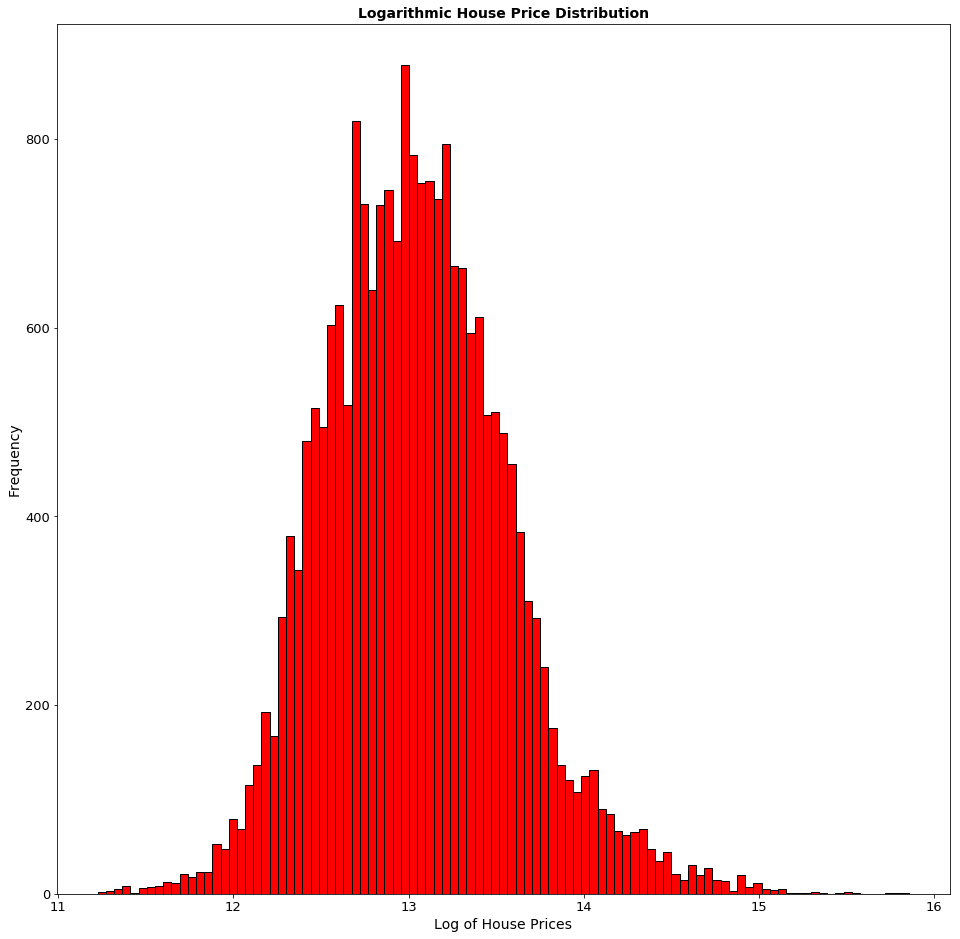

In [3]:
# Statistical Metrics for House Prices
minPrice = df.loc[:,'price'].min()
maxPrice = df.loc[:,'price'].max()
priceMean = df.loc[:,'price'].mean()
priceMode = df.loc[:,'price'].mode()
priceStats = df.loc[:,'price'].describe()

print("Minimum House price: ", minPrice, "$")
print("Maximum House price: ", maxPrice, "$")

print("Mean of House prices: ", priceMean)
print("\nMode of House prices: ")
display(priceMode)

print("Statistics about House Price: ")
display(priceStats)

# Histogram of log of House Prices
fig = plt.figure(figsize = (16, 16))
plt.hist(np.log(df['price']), bins = 99, edgecolor = 'black', color = 'red')
plt.xlabel('Log of House Prices', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.tick_params(labelsize = 13)
plt.title('Logarithmic House Price Distribution', fontsize = 14, fontweight = 'bold')
plt.savefig(f"figures/logHist.jpg")

The statistical values along with the histogram clearly show that the prices are normally distributed with minimal skewness and most of the houses with prices 350k and 450k dollars. This provides reassurance that there will be no bias in the model as far as the house prices are concerned. The next step is to find the correlation between each feature with the price to understand the proportionalities between the two quantities which would provide useful information for *Feature Selection*. Before this, the feature **date** and **id** will be discarded from the dataset as they do not significantly (or at all) affect the price of the houses.     

In [4]:
# Drop unnecessary columns are display the updated dataset
df = df.drop(['id', 'date'], axis = 1)
display(df.head())

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [5]:
# Correlation of all the features with the price of the house
most_corr = df.corr()['price'].abs().sort_values(ascending = False)

# Feature count
F = 4

# Retain the top 4 most correlated features with the price
most_corr = most_corr[1:F + 1]

'''
Preparation of the data for the 
Stan Model (samples for convergence and predictions)
'''
totalSamples = 2000
df = df.sample(n = totalSamples)

# Store the prices in the label set
labels = df['price']

'''
# Trim down the dataframe to the desired number of features 
and without the labels ('price')
'''
df = df.loc[:, most_corr.index]

As per the scope of the project and the size of the dataset, we have decided to shortlist a total of four features from the dataset with the highest magnitude of correlation values for creating our Bayesian model. As can be seen from the correlation values, the three selected features are **sqft_living**, **grade**, **sqft_above**, and **sqft_living15**. The detailed descriptions of each of these features are as follows:  

1. **sqft_living:** Square Footage of each home.
2. **grade:** Overall grade given to the housing unit based on King County grading system.
3. **sqft_above:** Square Footage of house apart from the basement.
4. **sqft_living15:** Living room area in 2015 (implies -- some renovations) This might or might not have affected the lot size area.  

After selecting the best features, the dataset has been divided into a separate *training set* (all selected features) and a *test set* (list of all labels, i.e., **price**). Moreover, a subsample of the dataset roughly 10% of the original one has been extracted randomly for creating the Bayesian Model. The split ratio for train and test sets has been set to *90:10*. In addition to this, the feature dataset has been scaled using the **Standard Scaler** to ensure that the mean and variance of the feature distribution stays close to 0 and 1 respectively.  

In [6]:
# Create train and test splits for the features and labels
x_train, x_test, y_train, y_test = train_test_split(df, labels,
                                                    test_size = 0.1,
                                                    random_state = 42)

# Type conversion of splits
x_train = x_train.values
x_test = x_test.values
y_train = y_train.values
y_test = y_test.values

XTrain = x_train.astype(str).astype(float)
YTrain = y_train.ravel().astype(str).astype(float)
XTest = x_test.astype(str).astype(float)
YTest = y_test.ravel().astype(str).astype(float)

# Scaling of the train and test data for the model
scaler = StandardScaler()
scaler_new = StandardScaler()

XTrain_Scaled = scaler.fit_transform(XTrain)
XTest_Scaled = scaler.transform(XTest)

YTrain_Scaled = scaler_new.fit_transform(YTrain.reshape(-1, 1)).ravel()
YTest_Scaled = scaler_new.transform(YTest.reshape(-1, 1)).ravel()

# Input data for Stan model (Linear Regression)
data_linear = dict(
    tN = len(XTest_Scaled),
    N = len(XTrain_Scaled),
    F = F,
    y = YTrain_Scaled,
    x = XTrain_Scaled,
    x_test = XTest_Scaled
)

# Input data for Stan model (Polynomial Regression)
data_poly = dict(
    tN = len(XTest_Scaled),
    N = len(XTrain_Scaled),
    F = F,
    y = YTrain_Scaled,
    x = XTrain_Scaled,
    x_2 = np.square(XTrain_Scaled),
    x_test = XTest_Scaled,
    x_test_2 = np.square(XTest_Scaled)
)

## Bayesian Modeling

A regression model provides an equation where the *coefficients* represent the relationship between the independent variable(s), i.e., **features** and the dependent variable, i.e., the **price**. The *intercept* is the expected mean value of price if all features are equal to zero. Based upon our dataset having multiple features and a positive numbered label which is *non-categorical* and *non-ordinal*, the **linear** and **polynomial** regression models are best-suited for predicting the house prices. Our goal is to carry out a comparative analysis of the *Linear Regression* model and the *Polynomial Regression* model of **degree** 2 to find out which model is relatively appropriate for our dataset. The equation for a **linear regression model** is provided below:  

$$\boldsymbol{y} = \beta_{0} + \beta_{1}\boldsymbol{x} + \varepsilon $$  

Similarly, the equation for a **polynomial regression model** is provided below:  

$$\boldsymbol{y} = \beta_{0} + \beta_{1}\boldsymbol{x} + \beta_{2}\boldsymbol{x^2} + \varepsilon $$  

As apparent from the trimmed dataset and the correlation values, there is no *hierarchy* in the data to enable us to explore **separate** and **hierarchal** models for Stan. Hence, both Stan models for *linear* and *polynomial* regression are **pooled** models [3].    

For our problem, we have chosen weakly informative priors as defined in Gelman 2008. To get the best result out of Stan, dataset instability has to be prevented, which can typically arise from bad geometry in the posterior that can cause Stan to adapt poorly and have heavy tails. Looking at the logarithmic plot of the **price**, the ideal choice is to proceed with the **weakly informative prior**. The reason behind this is the fact that the prior rules out unreasonable parameter values but is not so strong as to rule out values that might make sense. Furthermore, the loss in precision by making the prior a bit too weak is less serious than the gain in robustness by including parts of parameter space that might be relevant. As a result, the Cauchy distribution, i.e., $\mathcal{N} \sim Cauchy (\mu, \gamma)$ with mean 0 and a long tail is perceived to be the best choice for the problem at hand [4]. The Cauchy prior incorporated for the *coefficients* is as follows:

$$\mathcal{N} \sim Cauchy (0, 2.5) $$  

Similarly, the prior incorporated for the *intercept* is as follows:

$$\mathcal{N} \sim Cauchy (0, 10) $$

In our Stan model, we first construct the data block, which includes the *features*  and *prices* of the **training set** along with their *count* and lastly, the *features* of the **test set** along with their *count*.  We then initialize our parameters which in our case are the *intercept, slope values*, and the *variance*. The intercept and slope parameters are transformed into another parameter which can be considered as the **expected mean** of the price distribution.   

We subsequently model the house prices as a normal sample with a mean that is the transformed parameter computed earlier.   

Once the model is fitted, the parameters are then used to predict the house prices of the test set and also the log-likelihood values are generated in order to calculate the PSIS-LOO values (for performance analysis later on).   

In [7]:
# Stan models compilation (for both Linear and Polynomial Regression)
model_linear = stan_utility.compile_model(filename = 'model_trial.stan',
                                          model_name = 'linear')
model_poly = stan_utility.compile_model(filename = 'model_trial_2.stan',
                                        model_name = 'polynomial')

Using cached StanModel
Using cached StanModel


In [8]:
# Linear Regression model

'''
Model fitting with default parameters 
and displaying the results (random seed to reproduce results)
'''
fit_linear = model_linear.sampling(data = data_linear,
                                   seed = 194838, n_jobs = -1)

'''
# Extraction of Posterior Predictive samples 
from the model (Linear Regression)
'''
samples_linear = fit_linear.extract(permuted = True)

# Ensuring that parameters to the Stan model are fine tuned
stan_utility.check_treedepth(fit_linear)

0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)


In [9]:
# Polynomial Regression model

'''
# Model fitting with default parameters 
and displaying the results (random seed to reproduce results)
'''
fit_poly = model_poly.sampling(data = data_poly,
                               seed = 194838, n_jobs = -1)

'''
# Extraction of Posterior Predictive samples 
from the model (Polynomial Regression)
'''
samples_poly = fit_poly.extract(permuted = True)

# Ensuring that parameters to the Stan model are fine tuned
stan_utility.check_treedepth(fit_poly)

0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)


After observing the $\boldsymbol{\hat{R}}$ of both the models, it is safe to state that both models have converged with the default *iteration* and *chain* settings of Stan. Since the house **prices** had been scaled before being fitted in the models, therefore we would have to *unscale* them to their original values for future comparative analysis. The results of $\boldsymbol{\hat{R}}$ and $\boldsymbol{n_{eff}}$ clearly signify that the choice of models was appropriate for the given problem.  

Please refer to the **Appendices** section for the Stan model *code* and *results* of the *Linear* and *Polynomial* regression models.  

## Comparative Analysis of the Models

For this problem, the efficiency of the models that we chose to fit the *training set* and utilize it to make predictions for the *test set* can be analyzed by the following means:  

   1. Visual Depiction of the Original vs. the Predicted House Prices
   2. Root Mean Squared (RMS) error
   3. PSIS-LOO CV (leave-one-out cross-validation) values along with Pareto k-value estimates for the models.  
    
Firstly, we *unscaled* the predicted prices retrieved from the **linear** and **polynomial** regression models in Stan and generated a visual illustration to enable a 3-way comparison between these two sets of values and the original house **prices** as shown below:  

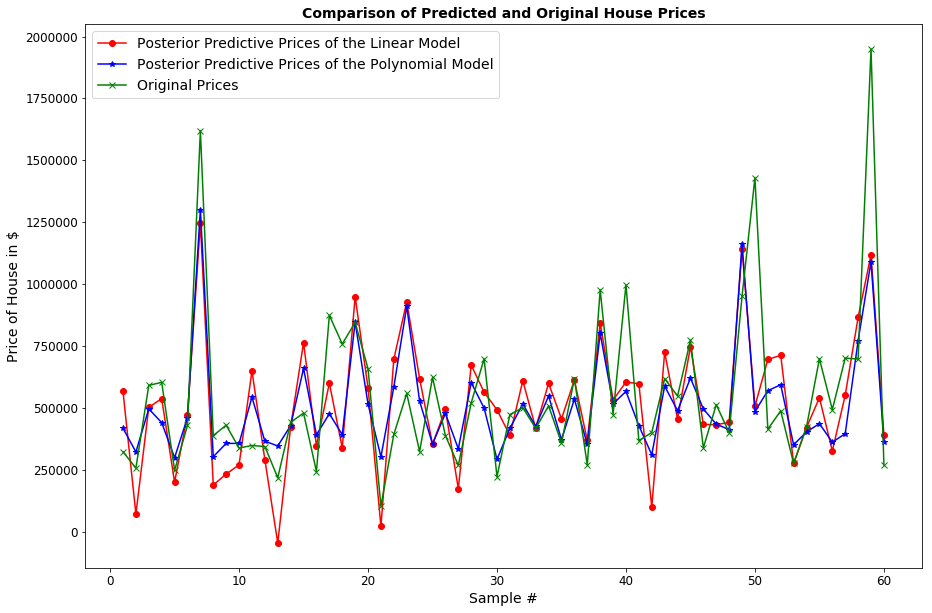

In [10]:
'''
Extract the predictive posterior values from the model 
and the original 'Price' value from the dataset 
'''
y_ax_linear = samples_linear['y_predicted'].mean(axis = 0) 
y_ax_poly = samples_poly['y_predicted'].mean(axis = 0)  

# Scale back prediction to original values
y_linear_unscaled = scaler_new.inverse_transform(y_ax_linear)
y_poly_unscaled = scaler_new.inverse_transform(y_ax_poly)
YTest_Unscaled = scaler_new.inverse_transform(YTest_Scaled)

'''
# Extract a fraction (30%) of the Predictive Posterior 
values from the test samples and original samples
'''
predictionSamples = int(len(YTest_Scaled) * 0.3)
x_ax = np.arange(1, predictionSamples + 1, 1)

# Plot the predictions from both models vs. original values
fig = plt.figure(figsize = (15, 10))
plt.xlabel('Sample #', fontsize = 14)
plt.ylabel('Price of House in $', fontsize = 14)
plt.plot(x_ax, y_linear_unscaled[:predictionSamples],
         label = "Posterior Predictive Prices of the Linear Model",
         marker = 'o', c = 'red')
plt.plot(x_ax, y_poly_unscaled[:predictionSamples],
         label = "Posterior Predictive Prices of the Polynomial Model",
         marker = '*', c = 'blue')
plt.plot(x_ax, YTest_Unscaled[:predictionSamples],
         label = "Original Prices", marker = 'x', c = 'green')
plt.legend(fontsize = 14)
plt.tick_params(labelsize = 12)
plt.title('Comparison of Predicted and Original House Prices',
          fontsize = 14, fontweight = 'bold')
plt.savefig(f"figures/priceCompare.jpg")

From the figure above, it can be observed that **polynomial** model made *price* predictions much closer to the original than the **linear** model. Although both models were able to adapt quite well to the sensitivity of the dataset, there were certain samples where both the models would seem to go wayward (between samples 30-35 and 50-55) and loose precision.  

Next, we calculated the Root Mean Squared (RMS) error for both the models. The RMS of the pairwise differences of the *training* and *test* sets can serve as a measure how far on average the error is from 0. Thus, the RMS of the differences is a meaningful measure of the error.  

In [11]:
# Root Mean Squared (RMS) error for both models
rms_linear = 0
rms_poly = 0

for i in range(0, np.size(YTest_Scaled)):
    rms_linear = rms_linear + np.sqrt(np.abs(YTest_Scaled[i] - y_ax_linear[i]))
    rms_poly = rms_poly + np.sqrt(np.abs(YTest_Scaled[i] - y_ax_poly[i]))
    
rms_linear = rms_linear / predictionSamples
rms_poly = rms_poly / predictionSamples

print("RMS error of the Linear model: ", rms_linear)
print("RMS error of the Polynomial model: ", rms_poly)

RMS error of the Linear model:  2.0367331131261714
RMS error of the Polynomial model:  1.892379837584831


As signified by the visual illustration, the RMS error also agrees with the fact that the **polynomial** model provides relatively accurate house *price predictions* as compared to the **linear** model.  

Lastly, we proceed to the final means of model evaluation and comparison, i.e., the PSIS-LOO values. The **log-likelihood** calculation is necessary for obtaining the desired values, hence the code provided below utilizes these values from the Stan models to extract the **sum of the expected log predictive densities**, the **estimated an effective number of parameters** and lastly the **Pareto k-estimates** for the models [5]. The extraction process is provided as follows:   

In [12]:
# PSIS-LOO values for Linear model
log_lik_linear = samples_linear["loglik_pred"]
loo_linear, loos_linear, ks_linear = psis.psisloo(log_lik_linear)

print("Linear Model: ")
print("PSIS-LOO value:", loo_linear)

lppd_linear = np.sum(logsumexp(log_lik_linear, axis = 0,
                               b = 1. / log_lik_linear.shape[0]))
p_loo_linear = lppd_linear - loo_linear

print("Estimated effective number of parameters in the model: ",
      p_loo_linear)

ksn1 = (ks_linear >= 0.7).sum()
print("Number of k values greater than 0.7: ", ksn1)

Linear Model: 
PSIS-LOO value: -182.19221440541173
Estimated effective number of parameters in the model:  1.4639912814650984
Number of k values greater than 0.7:  0


In [13]:
# PSIS-LOO values for Polynomial model
log_lik_poly = samples_poly["loglik_pred"]
loo_poly, loos_poly, ks_poly = psis.psisloo(log_lik_poly)

print("Polynomial Model: ")
print("PSIS-LOO value:", loo_poly)

lppd_poly = np.sum(logsumexp(log_lik_poly,axis = 0, b = 1. / log_lik_poly.shape[0]))
p_loo_poly = lppd_poly - loo_poly

print("Estimated effective number of parameters in the model: ", p_loo_poly)

ksn2 = (ks_poly >= 0.7).sum()
print("Number of k values greater than 0.7 : ", ksn2)

Polynomial Model: 
PSIS-LOO value: -163.05427469903623
Estimated effective number of parameters in the model:  2.6930163794455666
Number of k values greater than 0.7 :  0


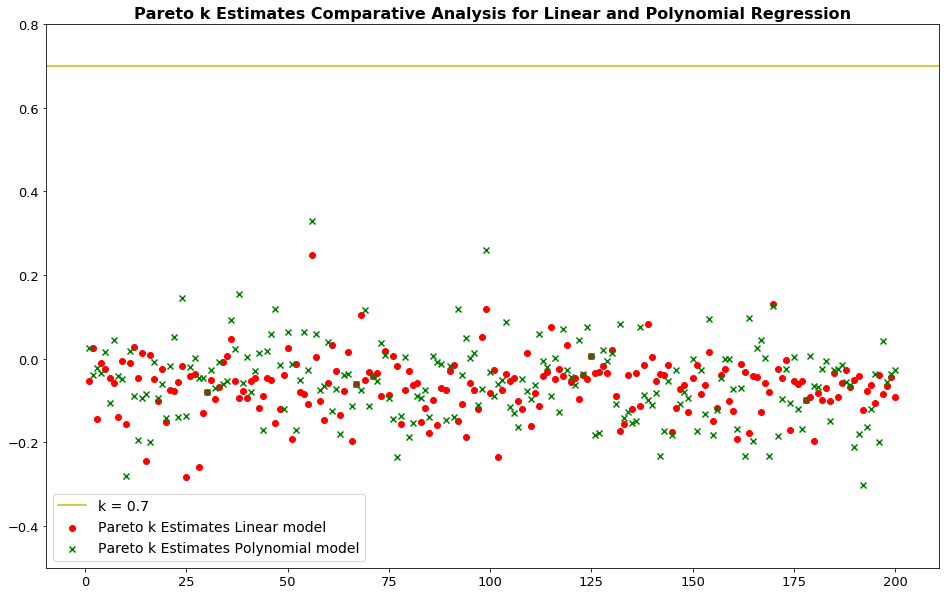

In [14]:
'''
Scatter plots for Pareto k-values for 
Linear and Polynomial Regresion models
'''
x_linear = np.arange(1, np.size(ks_linear) + 1, 1)
x_poly = np.arange(1, np.size(ks_poly) + 1, 1)

fig = plt.figure(figsize = (16, 10))
plt.axhline(y = 0.7, color = 'y', linestyle = '-',
            label = 'k = 0.7')
plt.scatter(x_linear, ks_linear,
            label = "Pareto k Estimates Linear model",
            marker = 'o', c = 'red')
plt.scatter(x_poly, ks_poly,
            label = "Pareto k Estimates Polynomial model",
            marker = 'x', c = 'green')
plt.tick_params(labelsize = 13)
plt.ylim((-0.5, 0.8))   
plt.title("Pareto k Estimates Comparative Analysis for Linear and Polynomial Regression",
          fontsize = 16, fontweight = 'bold')
plt.legend(fontsize = 14)
plt.savefig(f"figures/paretoKEstimates.jpg")

Results obtained from the PSIS-LOO CV (leave-one-out cross-validation) highlight two things:  

   1. The larger LOO value of the polynomial model as compared to that of the linear model signifies that the **polynomial** model is relatively more reliable as compared to the **linear** one.  

   2. Furthermore, the Pareto k estimates for both the models are **< 0.7** which signifies that the estimates for both the models are reliable.  

After our careful analysis and model assessment through the visualization of the house **prices**, the **RMS errors** and the **PSIS-LOO CV values**, we have identified the polynomial regression model as the better-suited model for our problem.  

## Conclusion

As a reflection of our entire progress, we were able to study, dissect and analyze the original dataset of house **prices** and get a better idea of how well they were distributed with the means of some statistical indicators and a logarithmic plot.   

Next, we were able to identify the right balance of the *training* and *test* from the original data to create Bayesian predictive models, i.e., the **Linear Regression Model** and the **Polynomial Regression Model** respectively.   

Subsequently, we justified the choice of these models along with the choice for the *prior* based upon the nature of the data, i.e., the **features** and **labels**.  

Lastly, we performed the model assessment of the chosen models through visualization of the *predicted prices* and the analysis of the RMS and PSIS-LOO CV values and indicators. Side-by-side comparison and plot depictions helped us in identifying the **polynomial** model better suited for predicting the house prices as compared to the **linear** model.  

Due to limited time, we rushed through the model selection process although the prior selection was appropriate. We could have explored other possible models for this problem and carried out an extensive assessment to find out the best choice. Also, some additional plots for analyzing the individual correlations between the features and the price would also have been advantageous.  

Some future improvements for this work could be analyzing more choices of models for Stan in addition to extensive fiddling with the iterations and number of chains for each model. In addition to this, Area Under the Curve (AUC) and Receiver Operating Curve (ROC) could be employed in future analysis to provide more insight into the model assessment phase.  

## References

[1]    House Sales in King County, USA - https://www.kaggle.com/harlfoxem/housesalesprediction/version/1  

[2]    Bayesian Linear Regression in Python: Using Machine Learning to Predict Student Grades Part 1 - https://towardsdatascience.com/bayesian-linear-regression-in-python-using-machine-learning-to-predict-student-grades-part-1-7d0ad817fca5  

[3]    A Primer on Bayesian Multilevel Modeling using PyStan - http://mc-stan.org/users/documentation/case-studies/radon.html  

[4]    Prior Choice Recommendations - https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations  

[5]    Pareto smoothed importance sampling (PSIS) - http://mc-stan.org/loo/reference/psis.html  

## Appendices

### Stan Code

#### Linear Regression

```
data {  
    int <lower=0> N; // Number of data points
    int <lower=0> tN; // Number of data to test
    int <lower=0> F; // Number of features
    real y[N]; // Price
    matrix[N, F] x; // Feature values
    matrix[tN, F] x_test; // Test feautures
}
parameters {
    real intercept;
    vector[F] theta;
    real sigma;
}
transformed parameters{
    vector[N] y_mean;
    y_mean = intercept + x * theta;
}
model {
    intercept ~ cauchy(0,10); //prior for the intercept following Gelman 2008
    for(i in 1:F)
       theta[i] ~ cauchy(0,2.5);//prior for the slopes following Gelman 2008
    y ~ normal(y_mean, sigma);
}
generated quantities {
    real ypred[tN];
    vector[tN] y_predicted;
    vector[tN] loglik_pred;
    for (i in 1:tN){
        y_predicted[i] = intercept + x_test[i] * theta;
        ypred[i] = normal_rng(y_predicted[i], sigma);
        loglik_pred[i] = normal_lpdf(y[i] | y_mean[i],sigma);
    }
}
```

#### Polynomial Regression

```
data {  
    int <lower=0> N; // Number of data points
    int <lower=0> tN; // Number of data to test
    int <lower=0> F; // Number of features
    real y[N]; // Price
    matrix[N, F] x; // Feature values
    matrix[N, F] x_2;
    matrix[tN, F] x_test; // Test feautures
    matrix[tN, F] x_test_2;
}
parameters {
    real intercept;
    vector[F*2] theta;
    real sigma;
}
transformed parameters{
    vector[N] y_mean;
    y_mean = intercept + x * theta[1:F] + x_2 * theta[F+1:F*2];
}
model {
    intercept ~ cauchy(0,10); //prior for the intercept following Gelman 2008
    for(i in 1:F)
       theta[i] ~ cauchy(0,2.5);//prior for the slopes following Gelman 2008
    y ~ normal(y_mean, sigma);
}
generated quantities {
    real ypred[tN];
    vector[tN] y_predicted;
    vector[tN] loglik_pred;
    for (i in 1:tN){
        y_predicted[i] = intercept + x_test[i] * theta[1:F] + x_test_2[i] * theta[F+1:F*2];
        ypred[i] = normal_rng(y_predicted[i], sigma);
        loglik_pred[i] = normal_lpdf(y[i] | y_mean[i],sigma);
    }
}
```

### Linear Regression Model Results

In [15]:
# Display results of Linear Stan Model
print(fit_linear)

Inference for Stan model: anon_model_23307f82cce8b5150747ec40c2ddb2a2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
intercept        3.6e-5  2.2e-4   0.02  -0.03  -0.01 8.6e-7   0.01   0.03   5106    1.0
theta[1]           0.72  5.8e-4   0.04   0.65   0.69   0.72   0.74   0.79   3732    1.0
theta[2]            0.3  3.9e-4   0.03   0.25   0.29    0.3   0.32   0.36   4547    1.0
theta[3]          -0.24  5.8e-4   0.03  -0.31  -0.26  -0.24  -0.22  -0.18   3538    1.0
theta[4]          -0.01  3.8e-4   0.03  -0.06  -0.03  -0.01 4.4e-3   0.04   4653    1.0
sigma              0.66  1.5e-4   0.01   0.64   0.65   0.66   0.67   0.68   5416    1.0
y_mean[1]          -1.0  4.3e-4   0.03  -1.06  -1.02   -1.0  -0.98  -0.95   4585    1.0
y_mean[2]          0.41  4.2e-4   0.03   0.35   0.39   0.41   0.43   0.46   4720    1.0
y_mean[3]          

### Polynomial Regression Model Results

In [16]:
# Display results of Polynomial Stan Model
print(fit_poly)

Inference for Stan model: anon_model_fdf10200661fa3c5ef96589091fabb87.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
intercept         -0.15  3.0e-4   0.02  -0.18  -0.16  -0.15  -0.14  -0.11   3390    1.0
theta[1]           0.35  6.7e-4   0.03   0.28   0.33   0.35   0.37   0.41   2454    1.0
theta[2]           0.31  3.9e-4   0.02   0.27   0.29   0.31   0.33   0.36   3516    1.0
theta[3]          -0.22  6.3e-4   0.03  -0.28  -0.24  -0.22   -0.2  -0.15   2615    1.0
theta[4]           0.12  4.5e-4   0.02   0.07    0.1   0.12   0.14   0.17   3032    1.0
theta[5]           0.17  2.1e-410.0e-3   0.15   0.16   0.17   0.17   0.19   2322    1.0
theta[6]           0.06  1.7e-4   0.01   0.04   0.05   0.06   0.07   0.08   3649    1.0
theta[7]          -0.04  2.7e-4   0.01  -0.07  -0.05  -0.04  -0.04  -0.02   2522    1.0
theta[8]          -